In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/Caskroom/miniforge/base/envs/d2l/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `

In [2]:
def masked_softmax(X, valid_lens):
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=1e-6)

        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [3]:
masked_softmax(torch.rand(2,2,4), torch.tensor([2, 3]))

tensor([[[0.2875, 0.2520, 0.2303, 0.2303],
         [0.3312, 0.3038, 0.1825, 0.1825]],

        [[0.2775, 0.2372, 0.3182, 0.1671],
         [0.2156, 0.2815, 0.3120, 0.1909]]])

In [4]:
masked_softmax(torch.rand(2,2,4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[0.4510, 0.1830, 0.1830, 0.1830],
         [0.3138, 0.3177, 0.1896, 0.1789]],

        [[0.3628, 0.2447, 0.1962, 0.1962],
         [0.2810, 0.1891, 0.3482, 0.1817]]])

In [24]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.V = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.V(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [31]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.normal(0, 1, (2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
queries.shape, keys.shape, values.shape

(torch.Size([2, 1, 20]), torch.Size([2, 10, 2]), torch.Size([2, 10, 4]))

In [34]:
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[18.0708, 19.0708, 20.0708, 21.0708]],

        [[18.2420, 19.2420, 20.2420, 21.2420]]], grad_fn=<BmmBackward0>)

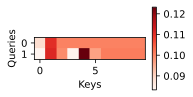

In [35]:
d2l.show_heatmaps(attention.attention_weights.reshape((1,1,2,10)),
                  xlabel='Keys', ylabel='Queries')

## 缩放点积注意力

In [36]:
class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        d = keys.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [37]:
queries = torch.normal(0, 1, (2, 1, 2))
keys = torch.normal(0, 1, (2, 10, 2))
attention = DotProductAttention(dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[19.1631, 20.1631, 21.1631, 22.1631]],

        [[18.6628, 19.6628, 20.6628, 21.6628]]])

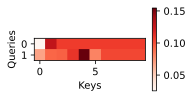

In [ ]:
d2l.show_heatmaps(attention.attention_weighies')